In [4]:
from collections import defaultdict
import numpy as np
import pdb
from sklearn.datasets import make_blobs
import random
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score

import seaborn as sns

from scipy.special import gamma

from joblib import Parallel, delayed
import math

In [5]:
from Wishart_baranov import *

In [6]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [21]:
# data generation 

N = 5
WINDOW_MIN = 8
WINDOW = 15

TRAIN_SIZE = 200
VAL_SIZE = 200
TEST_SIZE = 600
PTS = 100

train_start = 0
train_end = TRAIN_SIZE

val_init = TRAIN_SIZE + WINDOW - 1
val_start = val_init - 1
val_end = val_start + VAL_SIZE

test_init = val_end + WINDOW - 1
test_start = test_init - 1
test_end = test_start + TEST_SIZE - WINDOW

# clusterize data

WISHART_K = 11
WISHART_H = 0.2

# generate predictions

STEPS, EPS = 200, 0.25
# STEPS, EPS = 60, 0.025

Q_VALUE = 0.99

In [22]:
xs, _, _ = Lorentz().generate(0.1, 100000)
xs = (xs - xs.min()) / (xs.max() - xs.min())

In [23]:
x_train = xs[train_start:train_end]
x_val = xs[val_start:val_end]
x_test = xs[test_start:test_end]

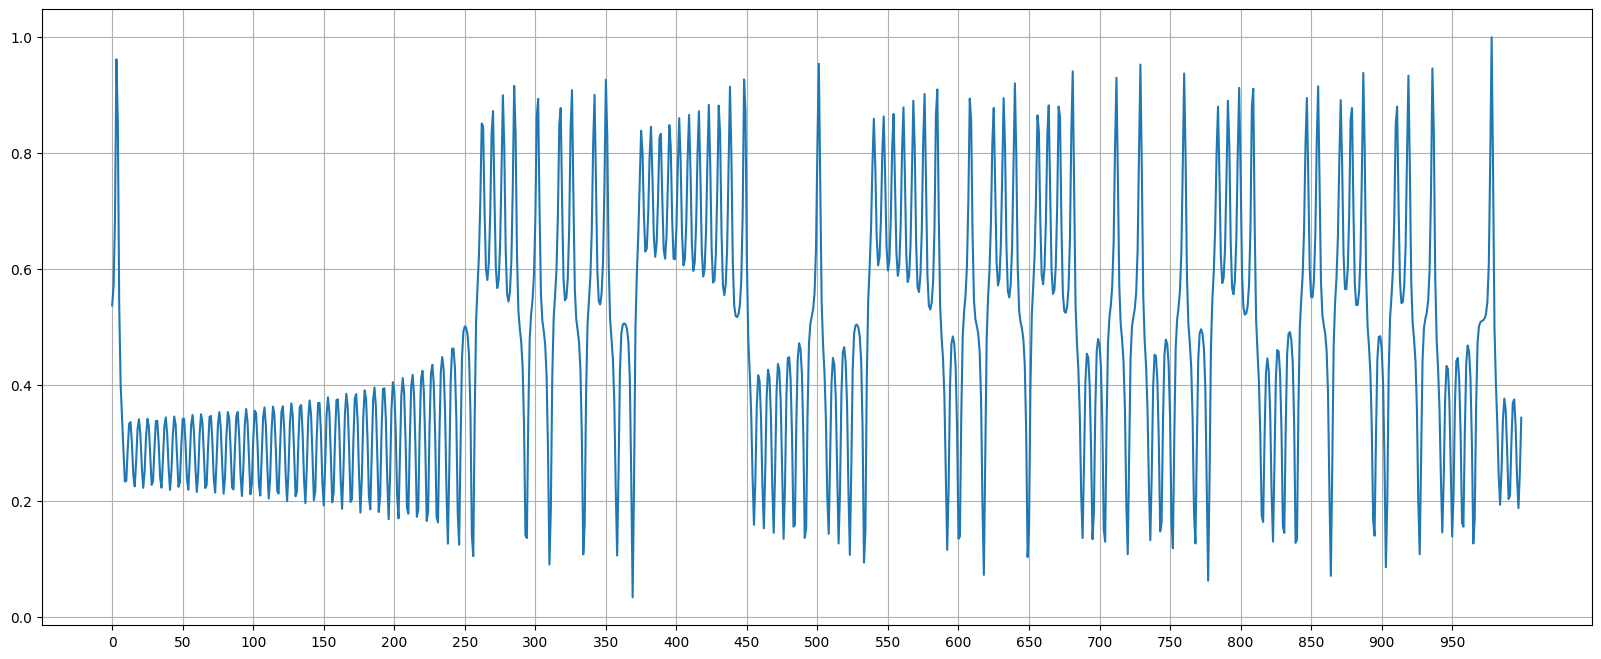

In [24]:
plt.figure(figsize=(20, 8))
plt.plot(xs[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

In [25]:
import itertools

def generate_subsequences(window, num, short=False, diff = None):
    # функция генерации шаблонов. Принимает:
    # window - максмальное расстояние между зубцами 
    # num - число зубцов шаблона 
    # short - если false - есть ограничение расстояние между зубцами снизу
    # window_min - минимальное расстояние между зубцами
    #
    
    values = list(range(window))
    result = []
    if short:
        for subseq in itertools.combinations(values, num):
            result.append(tuple([num + diff for num in subseq]))
    else:
        for subseq in itertools.combinations(values, num):
            result.append(subseq)
    
    return result


def generate_patterns(window, window_min, n, n_samples = None):
    # общая функция генерации шаблонов. Принимает:
    # window - максмальное расстояние между зубцами
    # window_min - минимальное расстояние между зубцами
    # num - число зубцов шаблона 
    patterns1 = generate_subsequences(window_min - 1, n - 1, short=True, diff = window - window_min)
    patterns2 = generate_subsequences(window - 1, n - 1)
    patterns2 = random.choices(patterns2[300:], k=35)
    
    if n_samples is None:
        return patterns1 + patterns2
    else:
        patterns = patterns1 + patterns2
        if len(patterns) < n_samples:
            return 'Error!'
        else:
            return patterns[:n_samples]

def str_subseq(subseq):
    # функция генерации названия по последовательности
    # принимает - последовательнось 
    # возвращает - ее название в виде стринги-последоватльности цифр
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))

In [26]:
def gen_sample_in_point(values, window, pattern, pos):
    # функция генерация 1 образца шаблона для конкретной стартовой точки. 
    # принимает: values - временной ряд, 
    # window - максимальное расстояние между зубцами, 
    # pattern - кодировку паттерна\
    # pos - стартовая точка, от которой считается паттерн. Если левая граница левее первого числа - возвращает None
    # возвращает - значения ряда от стартовой точки и далее с шагом в соотвествие с кодировкой паттерна.
    # Логика работы кодировщика - кодировка - номера элементов, которые берем, причем 1 элемент вне зависимости от позиции 
    # попадает в pos. Т.е. паттерн 7,8,9 вернет 3 последовательных значения от точки pos.  
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None

    
def gen_sample_in_point_2(values, window, pattern, pos):
    # функция генерация 1 образца шаблона для конкретной стартовой точки. 
    # принимает: values - временной ряд, 
    # pattern - кодировку паттерна\
    # pos - стартовая точка, от которой считается паттерн.
    # возвращает - значения ряда от стартовой точки и далее с шагом в соотвествие с кодировкой паттерна.
    # Кодировка паттерна - число шагов до следущего значения. Если значение 1 - берем следующее число за текущим. 
    # 0 недопустим и вернет то же значение
    # window - просто чтобы формат входа был тот же, что у базовой генерации
    if sum(pattern) + pos < len(values):
        template = []
        template.append(values[pos])
        curr_pos = pos
        for i in pattern:
            if i == 0:
                print('Error! This is the same step in template')
                return None
            curr_pos += i
            template.append(values[curr_pos])
            
        return template

    else:
        return None
    
    
def generate_sample(values, window, pattern, put_none=False):
    # функция генерация подвыборки из шаблона
    # принимает: values - временной ряд 
    # window - максимальное расстояние между зубцами, 
    # pattern - кодировку паттерна
    # put_none -  флаг того, что в подвыборку включаются пустые результаты
    # возвращает - 
    result = []
    for i in range(len(values)):
        res = gen_sample_in_point_2(values, window, pattern, i)
        if res == None:
            if put_none:
                result.append(res)
        else:
            result.append(res)
    return result




from itertools import groupby

def generate_centers(x_trains, input_params, get_clustering_func):
    # функция рассчета кластеров 
    # принимает - сет для кластеризации, входящие параметры, функцию кластеризации
    # возвращает словарь центров кластеров для каждого шаблона
    ws = {}
    for pattern, train in x_trains.items():
        # получаем лейблы кластеров
        ws[pattern] = get_clustering_func(train, input_params)


    centers = {}

    # cчитаем центроиды кластеров
    for pattern, w in ws.items():
        sorted_by_cluster = sorted(range(len(w)), key=lambda x: w[x])
        for wi, cluster in groupby(sorted_by_cluster, lambda x: w[x]):
            cluster = list(cluster)
            center = np.full(N, 0.0)
            for i in cluster:

                center += x_trains[pattern][i]
            centers.setdefault(pattern, []).append(center / len(cluster))
            
    return centers


def get_sample_for_template_back(prev_values,pattern):
    # функция генерации образца шаблона для теста.
    # принимает - точки до точки прогнозирования, формат шаблона
    # принцип шаблона - расстояние между наблюдениями, минимально 1 (в этом случае берется прошлое значение)
    # если 0 - вернет то же значение (что некорректно)
    # возращает урезанный образец шаблона (последнее значение попадает на точку прогноза)
    numer_pattern = pattern.split(',')
    reverse_pattern = [int(i) for i in numer_pattern]
    if sum(reverse_pattern) < len(prev_values):
        reverse_pattern.reverse()
        sample = []
        curr_pos = 0
        for i in reverse_pattern:
            curr_pos -= i
            sample.append(prev_values[curr_pos])

        sample.reverse()

        return sample
    else:
        print('Error')

In [27]:
x_trains = {}
patterns = generate_patterns(WINDOW, WINDOW_MIN, N, 2)

for pattern in patterns:
    key = str_subseq(pattern)
    x_trains[key] = generate_sample(x_train, WINDOW, pattern, put_none=False)

In [28]:
input_params = [WISHART_K,WISHART_H]

In [34]:
%%time
centers = generate_centers(x_trains, input_params, get_clustering)

CPU times: user 25.4 ms, sys: 1.35 ms, total: 26.7 ms
Wall time: 25.6 ms


In [35]:
centers

{'7,8,9,10': [array([0.30914556, 0.29179809, 0.28743166, 0.29363014, 0.28858861]),
  array([0.22955899, 0.25718286, 0.33989621, 0.25533121, 0.34280832])],
 '7,8,9,11': [array([0.32361677, 0.33630958, 0.28970699, 0.2612251 , 0.24289896]),
  array([0.23010555, 0.2499506 , 0.3327772 , 0.26379305, 0.34091352]),
  array([0.30556622, 0.28329458, 0.28723256, 0.29950781, 0.29780363])]}

In [30]:
def find_closest_motive(set_of_motives, sample, distant_func, eps):
    # функция поиска ближайших мотивов. Сравниваниет образец sample с усеченными образцами из set_of_motives. На вход 
    # идут полные образцы
    # принимает: набор мотивов, тестовый образец для шаблона, функцию рассчета расстония, 
    # максимальную дистанцию между схожими образцами.
    # возвращает мотивы, к которым образец не дальше, чем eps
    result_motives = []
    for i in set_of_motives:
        d = distant_func(i[:-1],sample)
        if d <= eps:
            result_motives.append(i)
            
    return result_motives


def get_possible_pred_values(motives, calculation_func):
    # общая функция получения возможных прогнозных значений (скаляров) из мотивов.
    # принимает: набор мотивов, из которых получаем прогнозные значения 
    # функцию получения прогнозных значений
    # возвращает: возможный набор прогнозных значений (set of possible values - sopv )
    
    return calculation_func(motives)

def get_last_point_as_pred(motives):
    # частная функция получения прогнозных значений из мотивов
    # принимает набор мотивов
    # возвращает: последние точки каждого из мотивов
    return [i[-1]for i in motives]

def get_UPV(union_of_sopv):
    # функция получения единого прогнозного значения
    # принимает - объединение sets of upv для разных шаблонов
    # возвращает  - среднее 
    all_values = np.array(list(union_of_sopv.values()))
    all_values = list(all_values.reshape(all_values.shape[0]*all_values.shape[1]))
    
    upv = np.mean(all_values)
    return upv

In [31]:
prev_values = x_test[:WINDOW*4]

In [32]:
union_of_sopv = {}

for key in centers.keys():

    set_of_motives = centers[key]
    sample = get_sample_for_template_back(prev_values,key)
    clos_motivs = find_closest_motive(set_of_motives, sample, euclidean, EPS)
    sopv = get_possible_pred_values(clos_motivs, get_last_point_as_pred)
    
    union_of_sopv[key] = sopv
    
pred = get_UPV(union_of_sopv)

In [33]:
pred 

0.26574378476166155